# TP1 - Programação Genética
## Júlia Fonseca de Sena - 2018054508

In [1]:
# Manipulação dos dados
import pandas as pd
import numpy as np
from copy import deepcopy

#Obtenção de números aleatórios
import random

# Métrica v_measure_score
from sklearn.metrics.cluster import v_measure_score

#Clusters hierarquicos
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

#Medir tempo
import time

#Coletor de lixo
import gc

#Gráfico
import matplotlib.pyplot as plt

# Parâmetros globais

In [2]:
#Tamanho da população
pop_size = 50

#Número de gerações
num_gen = 50

#Probabilidade dos operadores
p_crossover = 0.6
p_mutation = 0.3

#Tamanho do torneio
tournament_size = 5

#Classes de dados
class_df = 2

#Elitismo
flag_elitism = False

# Breast Cancer

## Treino
### Importar base de dados

In [3]:
df = pd.read_csv('breast_cancer_coimbra_train.csv')

#A última coluna é a classificação real, usada somente para o fitness
result_column = df.columns[len(df.columns)-1]

X = df.drop([result_column], axis=1)
df.head()

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
0,44,20.760000,86,7.553,1.600000,14.0900,20.320000,7.64000,63.610,1
1,46,20.830000,88,3.420,0.742368,12.8700,18.550000,13.56000,301.210,2
2,53,36.790166,101,10.175,2.534932,27.1841,20.030000,10.26309,695.754,1
3,54,30.483158,90,5.537,1.229214,12.3310,9.731380,10.19299,1227.910,1
4,34,24.242424,92,21.699,4.924226,16.7353,21.823745,12.06534,481.949,2


### Definir funções e terminais 

In [4]:
functions = np.array(['+', '-', '/', 'x'])

#2 * numero de colunas = numero de terminais (todos os parâmetros de cada ponto das operações)
terminals = np.array([])
for i in ['P1','P2']: #Os dois primeiros caracteres da string dos terminais indicam o ponto a que se refere
    point = i
    for j in range(X.shape[1]):
        terminals = np.append(terminals,[point+str(j)])
terminals

array(['P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18',
       'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28'],
      dtype='<U32')

In [5]:
def is_function(value): #Verifica se o valor passado é uma função
    if value in functions:
        return True
    
    return False

### Representação do indivíduo

In [6]:
class Node: #Nó da árvore
    def __init__(self, data):
        self.left = None 
        self.right = None
        self.data = data #String de uma função ou terminal

        
class Tree: #Árvore; representa a solução
    def __init__(self):
        self.root = Node(' ') #Inicializa a raiz com valor ' '
        self.height = 0 #Altura inicialmente 0
            
    def insert_functions(self, function): #Coloca função na solução
        if (self.root.data == ' '): #Se a raiz ainda não foi alterada
            self.root.data = function #Dá o valor
        else:
            node = self.root
            height = 0
            while(1):
                height += 1 #Todo loop do while é um nível a mais da árvore
                if random.randint(0, 1) == 0: #Escolhe aleatoriamente o nó da esquerda
                    if node.left == None: #Se está vazio
                        node.left = Node(function) #Cria nó com a função recebida
                        break #Sai do while, já inseriu a função
                    else:
                        node = node.left #Se não está vazio, procura no seu ramo um nó para inserir o valor
                        
                else: #Escolhe aleatoriamente o nó da direita
                    if node.right == None: #Mesmos procedimentos
                        node.right = Node(function)
                        break
                    else:
                        node = node.right
                        
            if height > self.height: #Se a altura em que nó foi criado for maior que a salva
                self.height = height #Atualiza
    
    def insert_terminals(self, node, height): #Coloca os terminais nos nós vazios a esquerda ou direita das funções
        if node.left == None: #Se nó à esquerda está vazio
            node.left = Node(terminals[random.randint(0, len(terminals)-1)]) #Coloca um terminal aleatório
        else:
            self.insert_terminals(node.left, height + 1) #Se não, busca por nós vazios em seu ramo
            
        if node.right == None: #Mesmos procedimentos para a direita
            node.right = Node(terminals[random.randint(0, len(terminals)-1)])
        else:
            self.insert_terminals(node.right, height + 1)
        
        if height > self.height: #Se a altura em que o nó foi criado for maior que a salva
            self.height = height #Atualiza
        
    def create_tree(self): #Criar/Popular árvore
        while(self.height < 6): #Coloca primeiro funções aleatórias até que a árvore tenha altura 6
                                #Todas possuem altura 7 na população inicial, mas não são full para mais diversidade
            self.insert_functions(functions[random.randint(0, 3)])
        self.insert_terminals(self.root, 1) #Coloca os terminais nos nós vazios a esquerda ou direita das funções
    
    def print_tree(self,node): #Imprime a árvore (DFS)
        if node == None:
            return
    
        print(node.data)
        if node.left != None:
            self.print_tree(node.left)
        if node.right != None:
            self.print_tree(node.right)
    
    def calculate_function(self,point1,point2): #Calcula a função representada para dois pontos
        def calculate(node, point1, point2): #Para cada nó, calcula o valor
            if is_function(node.data) == False: #Se é terminal
                col = int(node.data[2:]) #A coluna(parâmetro) é o inteiro a partir do terceiro caractere
                if (node.data[:2] == 'P1'): #Se do ponto 1
                    return point1[col] #Retorna o valor do parâmetro do ponto 1
                else: # Se do ponto 2
                    return point2[col] #Retorna o valor do parâmetro do ponto 2
            
            #Se é função
            if node.left != None: 
                left = calculate(node.left, point1, point2) #Calcula o valor do ramo da esquerda
            if node.right != None:
                right = calculate(node.right, point1, point2) #Calvula o valor do tamo da direita
            
            #Realiza as operações que a função representa e retorna o valor absoluto
            if node.data == '+':
                value = abs(np.add(left, right))
            elif node.data == '-':
                value = abs(np.subtract(left, right))
            elif node.data == 'x':
                value = abs(np.multiply(left, right))
            else:
                if right != 0:
                    value = abs(np.divide(left, right))
                else: #Se a divisão for por 0, retorna 0
                    value = 0
    
            return value
        
        
        return calculate(self.root,point1,point2) #Começando da raiz, calcula a função de distância para esses dois pontos
    
    def call_function(self,X): #Chama a função de distância para pares de pontos em X (necessário no cluster hierárquico)
        return pairwise_distances(X, metric=self.calculate_function)

### Operadores
#### Funções auxiliares

In [7]:
def check_height(node): #Retorna a profundidade máxima da árvore ou ramo
    if node == None: #Se não é um nó
        return -1 #Tira 1 da altura
        
    left = check_height(node.left) #Altura do ramo da esquerda
    
    right = check_height(node.right) #Altura do ramo da direita
    
    if left > right: #Retorna a maior altura encontrada
        return left + 1
    else:
        return right + 1
    
def pick_random_branch(ind): #Escolhe um ramo aleatório
    height = 0
    node = ind.root #Passa por toda a árvore
    while(1):
        if random.randint(0, 1) == 0: #Escolhe aleatoriamento o nó da esquerda
            if node.left != None: #Se não é vazio
                height += 1 #Adiciona 1 à altura do nó
                previous = node #Anterior ao próximo nó
                node = node.left #Novo nó
                side = 'l' #De qual lado está em relação ao anterior
                if random.randint(0, 1) == 0: #Parar por aqui
                    break
            else: #Se é vazio, parar e retornar o do último loop
                break
        else: #Escolhe o nó da direita
            if node.right != None: #Mesmos procedimentos
                height += 1
                previous = node
                node = node.right
                side = 'r'
                if random.randint(0, 1) == 0:
                    break
            else:
                break
                
    return height,node,previous,side

#### Cruzamento

In [8]:
def crossover(ind1, ind2):
    height1, branch1, previous1, side1 = pick_random_branch(ind1) #Escolhe um ramo aleatório de cada indivíduo
    height2, branch2, previous2, side2 = pick_random_branch(ind2)
    
    while (height1 + check_height(branch2) > 7) or (height2 + check_height(branch1) > 7): #Se troca causa alguma árvore com
                                                                                          #altura maior que 7; escolhe de novo
        height1, branch1, previous1, side1 = pick_random_branch(ind1)
        height2, branch2, previous2, side2 = pick_random_branch(ind2)
    
    #Já achou ramos que funcionam
    aux = branch2
    if side2 == 'l': #Verifiva de qual lado do anterior trocar
        previous2.left = branch1 #Coloca o ramo do outro indivíduo a esquerda
    else:
        previous2.right = branch1 #Coloca o ramo do outro indivíduo a direita
    
    if side1 == 'l': #O mesmo para o outro indivíduo
        previous1.left = aux
    else:
        previous1.right = aux

#### Mutação

In [9]:
def terminal_to_function(node,value,height): #Transforma um nó de terminal em um nó de função
    if is_function(value) == True: #Se valor novo é função
        node.data = value #Copia valor novo para nó
        
        if height == 7: #Se altura é 7
            node.data = terminals[random.randint(0, len(terminals)-1)] #Escolhe um terminal aleatório
            return                                                     #para por no lugar
        
        if node.left == None: #Se à equerda é vazio
            node.left = Node('') #Cria nó
            if random.randint(0, 1) == 0: #Cria ramo à esquerda a partir de função
                terminal_to_function(node.left,functions[random.randint(0, 3)],height+1)
            else: #Cria ramo à direita com terminal
                terminal_to_function(node.left,terminals[random.randint(0, len(terminals)-1)],height+1)
        if node.right == None: #Se à direita é vazio
            node.right = Node('') #Mesmos procedimentos
            if random.randint(0, 1) == 0:
                terminal_to_function(node.right,functions[random.randint(0, 3)],height+1)
            else:
                terminal_to_function(node.right,terminals[random.randint(0, len(terminals)-1)],height+1)
                
    else: #Se valor novo for terminal
        node.data = value #Só copia valor para o nó
    
    return

def mutation(ind): #Faz mutação em um nó aleatório
    height, node, previous, side = pick_random_branch(ind) #Escolhe o nó

    if random.randint(0, 1) == 0: #Faz mutação para uma função
        if is_function(node.data) == True: #Se nó já era função
            node.data = functions[random.randint(0, 3)] #Só altera a função
        else: #Se era terminal, precisa construir ramo, já que era folha
            terminal_to_function(node,functions[random.randint(0, 3)],height)
    else: #Faz mutação para um terminal
        node.data = terminals[random.randint(0, len(terminals)-1)] #Só altera o valor para terminal
        node.left = None #E torna folha
        node.right = None

#### Elitismo

In [10]:
def elitism(pop,fitness): #Retorna melhor indivíduo da população
    df_pop_fit = pd.DataFrame(data={'population': pop, 'fitness': fitness}) #Coloca em dataframe
    df_pop_fit = df_pop_fit.sort_values(by='fitness', ascending=False) #Ordena decrescentemente
    indexes = df_pop_fit.index #Pega índices na ordem decrescente
    
    return df_pop_fit.population[indexes[0]] #Retorna indivíduo com primeiro índice da ordem decrescente

#### Seleção (Torneio)

In [11]:
def selection_tournament(k,pop,fitness): #Faz seleção por torneio
    group_indexes = [] #Indexes dos indivíduo no grupo
    while len(group_indexes) < k: #Enquanto não tiver k membros
        j = random.randint(0, len(pop)-1) #Peha aleatório
        if j not in group_indexes:
            group_indexes.append(j) #Coloca se não já estiver no grupo

    max_fit = -1
    for i in group_indexes: #Encontra o index daquele com maior fitness
        if (max_fit == -1) or (fitness[i] > fitness[max_fit]):
            max_fit = i
    
    return max_fit #Retorna o index encontrado

### Fitness

In [12]:
def get_clusters(individual): #Retorna vetor com o cluster de cada linha da base de dados
                              #com base na função do indivíduo
    clusters = AgglomerativeClustering(n_clusters=class_df, affinity=individual.call_function, linkage='complete')
    clusters = clusters.fit_predict(X)
    
    return clusters

def fitness(pop): #Retorna vetor com a fitness de cada indivíduo na população recebida
    X_copy = X.copy()
    fitness = np.array([])
    
    for i in range(len(pop)): #Para cada indivíduo da população
        str_pred = 'y_pred'+str(i)
        clusters = get_clusters(pop[i]) #Acha os clusters previstos
        
        for i in range(len(clusters)):
            X_copy.loc[i,str_pred] = clusters[i] #Coloca na base de dados
        fitness = np.append(fitness,v_measure_score(df[result_column], X_copy[str_pred])) #Calcula a fitness comparando com a 
                                                                                          #classificação real
    
    return fitness

### Populações
#### População inicial

In [13]:
def create_initial_pop(size): #Cria população inicial
    pop = np.array([])
    for i in range(size): #Número de indivíduos da população
        ind = Tree()
        ind.create_tree()
        pop = np.append(pop,ind)
        
    return pop

#### Nova população

In [14]:
def new_population(pop, fitness): #Computa a nova população e fitness média dos pais de cada indivíduo criado
    new_pop = np.array([])
    parents_fitness = np.array([]) #Guarda as fitness dos pais de cada indivíduo
    
    if flag_elitism == True: #Se há elitismo
        parents_fitness = np.append(parents_fitness, -1) #Quando fitness dos pais não interessa, valor é -1
        higher = Tree()
        higher.root = deepcopy(elitism(pop,fitness).root) #Deep copy para não alterar o original com crossover/mutação
        new_pop = np.append(new_pop, higher) #Adiciona o melhor indivíduo à nova população
    
    while len(new_pop) < pop_size: #Enquanto não chegar ao tamanho da população
        ind1 = selection_tournament(tournament_size,pop,fitness) #Escolhe pai por torneio
        
        if (random.randint(0,100) <= p_crossover*100) and (len(new_pop) + 2 <= pop_size): # Chance de ser crossover
            ind2 = ind1
            while ind2 == ind1: #Se escolher o mesmo indivíduo, escolhe de novo
                ind2 = selection_tournament(tournament_size,pop,fitness) #Escolhe o outro pai por torneio
                
            tree_ind1 = Tree()
            tree_ind1.root = deepcopy(pop[ind1].root) #Deep copy para não alterar o pai
            tree_ind1.height = check_height(tree_ind1.root) #Coloca altura da árvore
            tree_ind2 = Tree()
            tree_ind2.root = deepcopy(pop[ind2].root)
            tree_ind2.height = check_height(tree_ind2.root)
            crossover(tree_ind1,tree_ind2) #Realiza crossover das deep copies
            
            avr_parent_fit = (fitness[ind1] + fitness[ind2])/2 #Fitness média dos pais
            parents_fitness = np.append(parents_fitness,[avr_parent_fit, avr_parent_fit]) #Adiciona duas vezes, já que foram
                                                                                          #criados dois filhos
            
            new_pop = np.append(new_pop,tree_ind1) #Coloca novos indivíduos na nova população
            new_pop = np.append(new_pop,tree_ind2)
            
        elif random.randint(0,100) <= (p_crossover + p_mutation)*100: #Chance de ser mutação
            tree_ind1 = Tree()
            tree_ind1.height = check_height(tree_ind1.root) #Coloca altura da árvore
            tree_ind1.root = deepcopy(pop[ind1].root) #Deep copy para não alterar o pai
            mutation(tree_ind1) #Mutação da deep copy
            
            parents_fitness = np.append(parents_fitness, -1) #Fitness do pai não interessa para estatística, coloca -1
            new_pop = np.append(new_pop,tree_ind1) #Coloca novo indivíduo na nova população
    
    return new_pop, parents_fitness

### Geração

In [15]:
def max_min_fitness(fitness): #Acha maior e menor fitness da geração
    sorted_fit = -np.sort(-fitness) #Ordena em ordem decrescente
    return sorted_fit[0], sorted_fit[len(fitness)-1]

def average_fitness(fitness): #Acha fitness média da geração
    return np.sum(fitness) / len(fitness)

def check_equal(node1, node2): #Checa se dois indivíduos são iguais
    if node1 == None and node2 == None: #Se ambos nós da recursão são None, retorna True
        return True
    
    if node1 != None and node2 != None: #Se ambos não são
                                        #Checa condições: valor igual e ramos da esquerda e da direita devem ser iguais
        return (node1.data == node2.data and check_equal(node1.left,node2.left) and check_equal(node1.right,node2.right))
    
    return False #Se só um é None, retorna False
        
def repeted_solutions(population): #Conta soluções repetidas
    num_equals = 0
    
    for i in range(len(population)-1): #Para toda a população
        ind1 = population[i]
        for j in range(i+1,len(population)): #Comparar com aqueles que ainda não houve comparação (à frente na população)
            ind2 = population[j]
            if (ind1.height == ind2.height): #Se as alturas forem iguais
                if check_equal(ind1.root, ind2.root) == True: #Checa se são iguais
                    num_equals += 1 #Se sim, aumenta o número de repetições
    
    return num_equals

def children_better_worse(parents_fitness, pop_fitness): #Conta os filhos melhores e piores que seus pais do crossover
    if len(parents_fitness) == 0: #Se não há dado de fitness dos pais: primeira geração
        return -1, -1 #Retorna valores padrões para a primeira geração
    
    better = 0
    worse = 0
    for i in range(len(pop_fitness)): #Para cada membro da população
        if parents_fitness[i] > -1: #Se é um valor do crossover (ao invés do elitismo e mutação)
            if parents_fitness[i] < pop_fitness[i]: #Se média dos pais for pior
                better += 1 #Aumenta em 1 filhos melhores
            elif parents_fitness[i] > pop_fitness[i]: #Se média dos pais for melhor
                worse += 1 #Aumenta em 1 filhos piores
    
    return better, worse

In [16]:
def generation(pop, parents_fit): #Cada geração retorna nova população, novo vetor de fitness dos pais e suas estatísticas
    statistics = [] #Lista que guarda estatísticas
    pop_fitness = fitness(pop) #Calcula fitness da população recebida
    
    #Cálculo das estatísticas
    max_f,min_f = max_min_fitness(pop_fitness)
    avr_fit = average_fitness(pop_fitness)
    equal_sol = repeted_solutions(pop)
    better_children, worse_children = children_better_worse(parents_fit,pop_fitness)
    statistics.append(max_f)
    statistics.append(min_f)
    statistics.append(avr_fit)
    statistics.append(equal_sol)
    statistics.append(better_children)
    statistics.append(worse_children)
    
    new_pop, new_parents_fit = new_population(pop,pop_fitness) #Recebe nova população e novo vetor de fitness dos pais
    return new_pop, new_parents_fit, statistics

### Algoritmo completo

In [17]:
def algorithm(): #Algoritmo; retorna melhor indivíduo, sua fitness e o dataframe com os dados das gerações
    #start_time_a = time.time()
    
    population = create_initial_pop(pop_size) #Cria população inicial
    parents_fit = np.array([]) #Array de fitness dos pais vazio
    
    #Dataframe inicialmente vazio
    df_stats = pd.DataFrame({'max_fit': [], 'min_fit': [], 'avr_fit': [], 'repeted_ind': [], 
                             'children_better': [], 'children_worse': []})
    
    for i in range(num_gen): #Faz o número de gerações requeridos; critério de parada
        #start_time_g = time.time()
        population, parents_fit, gen_stats = generation(population, parents_fit) #Computa geração
        #print(time.time() - start_time_g)
        #print(gen_stats)
        df_stats.loc[i] = gen_stats #Coloca suas estatísticas no Dataframe
        gc.collect()
    
    #Dados da população final
    gen_stats = []
    pop_fitness = fitness(population)
    
    #Estatísticas da última geração
    max_f,min_f = max_min_fitness(pop_fitness)
    avr_fit = average_fitness(pop_fitness)
    equal_sol = repeted_solutions(population)
    better_children, worse_children = children_better_worse(parents_fit,pop_fitness)
    gen_stats.append(max_f)
    gen_stats.append(min_f)
    gen_stats.append(avr_fit)
    gen_stats.append(equal_sol)
    gen_stats.append(better_children)
    gen_stats.append(worse_children)
    df_stats.loc[num_gen] = gen_stats #Coloca no dataframe
    
    max_fit_final = 0
    for i in range(1,len(pop_fitness)): #Acha o índice do maior fitness
        if pop_fitness[i] > pop_fitness[max_fit_final]:
            max_fit_final = i
    
    #print('algorithm time: ' + str(time.time() - start_time_a))
    gc.collect()
    return population[max_fit_final], pop_fitness[max_fit_final], df_stats #Retorna solução, fitness e dataframe

In [18]:
best_ind, best_fit, df_stats_train = algorithm()

### Estatísticas do treino

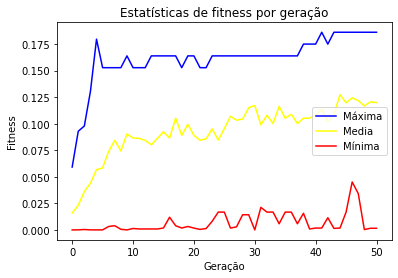

In [19]:
plt.title('Estatísticas de fitness por geração')
plt.xlabel('Geração')
plt.ylabel('Fitness')

plt.plot(df_stats_train.max_fit, label='Máxima', color='blue')
plt.plot(df_stats_train.avr_fit, label='Media', color='yellow')
plt.plot(df_stats_train.min_fit, label='Mínima', color='red')

plt.legend()
plt.show()

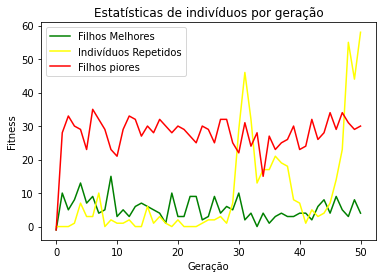

In [20]:
plt.title('Estatísticas de indivíduos por geração')
plt.xlabel('Geração')
plt.ylabel('Número de indivíduos')

plt.plot(df_stats_train.children_better, label='Filhos Melhores', color='green')
plt.plot(df_stats_train.repeted_ind, label='Indivíduos Repetidos', color='yellow')
plt.plot(df_stats_train.children_worse, label='Filhos piores', color='red')

plt.legend()
plt.show()

## Teste
### Importa segunda base de dados

In [21]:
df = pd.read_csv('breast_cancer_coimbra_test.csv')

X = df.drop([result_column], axis=1)
df.head()

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
0,71,25.510204,112,10.395,2.871792,19.0653,5.486100,42.74470,799.898,2
1,86,21.111111,92,3.549,0.805386,6.6994,4.819240,10.57635,773.920,1
2,75,27.300000,85,5.197,1.089638,10.3900,9.000805,7.57670,335.393,1
3,76,29.218408,83,5.376,1.100646,28.5620,7.369960,8.04375,698.789,1
4,34,21.470000,78,3.469,0.667436,14.5700,13.110000,6.92000,354.600,1


### Cálculo da fitness para o melhor indivíduo encontrado no treino

In [22]:
fitness([best_ind])[0]

0.06876466356517148